In [155]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyomo.opt import SolverFactory

In [156]:
# data
data = pd.read_excel('inputs.xlsx')

In [157]:
def solve_opt(data, pass_min=0, mult_1=1, mult_2=1, tee=False):
    model = pyo.ConcreteModel() # create model
    # vary mult 1 to create pareto front!!!
    t = 96
    k = 100
    D_passenger = (data['Total demand']* mult_1).tolist()
    O_energy = (data['Outage']* mult_2).tolist()
    Riding_price = 0.5
    P_buy = 0.1
    P_sell = 0.25
    alpha = 10
    beta = 5
    ch_eff = 0.90
    dch_eff = 1/0.9
    gama = 1 #0.5
    E_0 = 0.2
    E_min = 0.2
    E_max = 1
    R_bat = 130
    C_bat = 40
    Ah = 905452
    V = 512
    T = 96
    
    # sets
    model.T = pyo.RangeSet(t) # set of timesteps
    model.K = pyo.RangeSet(k) # set of buses

    # parameters
    model.D_passenger = pyo.Param(model.T, initialize=lambda model, t: D_passenger[t-1]) # operational voltage of charger n
    model.O_energy = pyo.Param(model.T, initialize=lambda model, t: O_energy[t-1]) # operational voltage of charger n
    
    

    # binary variables
    model.b = pyo.Var(model.K, model.T, within=pyo.Binary) # binary variable indicating if bus k is serving trip i at time t
    model.x = pyo.Var(model.K, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to charge
    model.y = pyo.Var(model.K, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to discharge

    # non-negative variables
    model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # energy level of bus k at time t
    model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity purchased from the grid at time t
    model.w_sell = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity sold to the grid at time t
    model.w_riding = pyo.Var(model.T, within=pyo.NonNegativeReals) # number of trips performed at time t
    model.d = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # total degradation cost of the bus k battery at time t

    # constraints
    model.constraints = pyo.ConstraintList()  # Create a set of constraints

    for k in model.K:
        for t in model.T:
            model.constraints.add(model.b[k,t] + model.x[k,t] + model.y[k,t] <=1)

    #for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) <= (model.D_passenger[t]))

    for t in model.T:
        model.constraints.add(sum(model.b[k, t] for k in model.K) == model.w_riding[t])
        
    model.constraints.add(sum(model.w_riding[t] for t in model.T) >= pass_min)
    
    model.constraints.add(sum(model.w_riding[t] for t in model.T) <= 8458)


    for k in model.K:
        for t in range(2,T+1):
            model.constraints.add(model.e[k,t] == model.e[k,t-1] + ch_eff*alpha*model.x[k,t] - gama*model.b[k,t] - dch_eff*beta*model.y[k,t])

    for t in model.T:
        model.constraints.add(sum(ch_eff*alpha*model.x[k,t] for k in model.K) == model.w_buy[t])

    for t in model.T:
            model.constraints.add(sum(dch_eff*beta*model.y[k,t] for k in model.K) == model.w_sell[t])

    for t in model.T:
        model.constraints.add(sum(dch_eff*beta*model.y[k,t] for k in model.K) <= (model.O_energy[t]))

    for k in model.K:
        for t in model.T:
            model.constraints.add(model.e[k,t] >= C_bat * E_min)

    for k in model.K:
        for t in model.T:
            model.constraints.add(E_max * C_bat >= model.e[k,t])          

    for k in model.K:
        model.constraints.add(model.e[k,1] == E_0*C_bat)

    for k in model.K:
        for t in model.T:
            model.constraints.add(model.d[k,t] == ((R_bat*C_bat*1000)/(Ah*V) * (beta*model.y[k,t])))

    # objective function
    def rule_obj(mod):
        return sum(Riding_price*mod.w_riding[t] for t in mod.T) - sum(P_buy*mod.w_buy[t] for t in mod.T) + sum(P_sell*mod.w_sell[t] for t in mod.T) - sum(mod.d[k,t] for k in mod.K for t in mod.T) 
    model.obj = pyo.Objective(rule=rule_obj, sense=pyo.maximize)
    
    # SOLVER
    opt = pyo.SolverFactory('gurobi')
    opt.options['timelimit'] = 60
    opt.options['mipgap'] = 0.01
    results = opt.solve(model, tee=tee)
    print(results)
    return model

In [158]:
# Save function
def save_to_excel(model, filename='output.xlsx', Riding_price = 0.5, P_buy = 0.1, P_sell = 0.25):

    # Create a dictionary to store variable values
    var_values = {}

    # Store values of binary variables
    var_values['b'] = {(k, t): pyo.value(model.b[k, t]) for k in model.K for t in model.T}
    var_values['x'] = {(k, t): pyo.value(model.x[k, t]) for k in model.K for t in model.T}
    var_values['y'] = {(k, t): pyo.value(model.y[k, t]) for k in model.K for t in model.T}

    # Store values of non-negative variables
    var_values['e'] = {(k, t): pyo.value(model.e[k, t]) for k in model.K for t in model.T}
    var_values['w_buy'] = {t: pyo.value(model.w_buy[t]) for t in model.T}
    var_values['w_sell'] = {t: pyo.value(model.w_sell[t]) for t in model.T}
    var_values['w_riding'] = {t: pyo.value(model.w_riding[t]) for t in model.T}
    var_values['d'] = {(k, t): pyo.value(model.d[k, t]) for k in model.K for t in model.T}

    # Store objective function values
    total_revenues = pyo.value(sum(Riding_price * model.w_riding[t] for t in model.T) - sum(P_buy * model.w_buy[t] for t in model.T) + sum(P_sell * model.w_sell[t] for t in model.T) - sum(model.d[k, t] for k in model.K for t in model.T))
    total_passengers = pyo.value(sum(model.w_riding[t] for t in model.T))
    total_power_provided = pyo.value(sum(model.w_sell[t] for t in model.T))
    total_energy_charged = pyo.value(sum(model.w_buy[t] for t in model.T))
    total_degradation = pyo.value(sum(model.d[k, t] for k in model.K for t in model.T))

    objective_values = {
        'total_revenues': total_revenues,
        'total_passengers': total_passengers,
        'total_power_provided': total_power_provided,
        'total_energy_charged': total_energy_charged,
        'total_degradation': total_degradation
    }

    # Convert dictionary to DataFrame and save to Excel
    with pd.ExcelWriter(filename) as writer:
        for var, values in var_values.items():
            df = pd.DataFrame.from_dict(values, orient='index', columns=[var])
            df.to_excel(writer, sheet_name=var)
        
        obj_df = pd.DataFrame.from_dict(objective_values, orient='index', columns=['Value'])
        obj_df.to_excel(writer, sheet_name='Objective_Function_Values')

In [159]:
def plot_variables(model, D_passenger, O_energy,t=96,k=100):
    
    # 1. Percentage of the fleet that is: serving a trip, charging, discharging, or idle
    serving = [sum(pyo.value(model.b[k, t]) for k in model.K) for t in model.T]
    charging = [sum(pyo.value(model.x[k, t]) for k in model.K) for t in model.T]
    discharging = [sum(pyo.value(model.y[k, t]) for k in model.K) for t in model.T]
    idle = [k - s - c - d for s, c, d in zip(serving, charging, discharging)]

    time_steps = range(1, t + 1)
    hours = [step / 4 for step in time_steps]  # Convert time steps to hours
    bar_width = 0.2  # Adjust the bar width to prevent overlap

    plt.figure(figsize=(15, 5))

    plt.bar(hours, serving, width=bar_width, label='Serving', color='blue', alpha=0.6)
    plt.bar(hours, charging, width=bar_width, bottom=serving, label='Charging', color='green', alpha=0.6)
    plt.bar(hours, discharging, width=bar_width, bottom=[s + c for s, c in zip(serving, charging)], label='Discharging', color='red', alpha=0.6)
    plt.bar(hours, idle, width=bar_width, bottom=[s + c + d for s, c, d in zip(serving, charging, discharging)], label='Idle', color='gray', alpha=0.6)
    plt.xlabel('Time [h]')
    plt.ylabel('Number of Vehicles')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.tight_layout()
    plt.show()

    # 2. Summation of the energy level of the fleet
    total_energy = [sum(pyo.value(model.e[k, t]) for k in model.K) for t in model.T]
    plt.figure(figsize=(7.5, 5))
    plt.plot(hours, total_energy, label='Total Energy Level')
    plt.xlabel('Time [h]')
    plt.ylabel('Energy [kWh]')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.tight_layout()
    plt.show()

    # 3. Chart with only w_buy and w_sell
    plt.figure(figsize=(7.5, 5))
    plt.plot(hours, [pyo.value(model.w_buy[t]) for t in model.T], label='Charging')
    plt.plot(hours, [pyo.value(model.w_sell[t]) for t in model.T], label='Discharging')
    plt.xlabel('Time [h]')
    plt.ylabel('Power [kW]')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    plt.tight_layout()
    plt.show()
    
    # 4. Plot number of vehicles serving a trip and passenger demand
    serving = [(sum(pyo.value(model.b[k, t]) for k in model.K)/k)*100 for t in model.T]
    hours = [step / 4 for step in time_steps]

    fig, ax1 = plt.subplots(figsize=(15, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Vehicles (%)', color=color)
    ax1.bar(hours, serving, width=bar_width, label='Vehicles Serving', color=color, alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Number of Passengers', color=color)
    ax2.plot(hours, D_passenger, label='Passenger Demand', color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)


    # Align the zero point for both y-axes
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)
    fig.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
    plt.show()

    # 5. Plot relation of vehicles discharging and the number of outage demand
    discharging = [(sum(pyo.value(model.y[k, t]) for k in model.K)/k)*100 for t in model.T]
    hours = [step / 4 for step in time_steps]

    fig, ax1 = plt.subplots(figsize=(15, 5))

    color = 'tab:red'
    ax1.set_xlabel('Time [h]')
    ax1.set_ylabel('Vehicles (%)', color=color)
    ax1.bar(hours, discharging, width=bar_width, label='Vehicles Discharging (%)', color=color, alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:green'
    ax2.set_ylabel('Power Demand [kW]', color=color)
    ax2.plot(hours, O_energy, label='Outage Demand', color=color, linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Align the zero point for both y-axes
    ax1.set_ylim(bottom=0)
    ax2.set_ylim(bottom=0)

    # Ensure both y-axes are well visible
    fig.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)
    plt.show()


In [160]:
model = solve_opt(data,pass_min=0,tee=True)

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2024-07-27
Read LP format model from file /var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmp8gi8hn8_.pyomo.lp
Reading time = 0.17 seconds
x1: 48486 rows, 48288 columns, 163680 nonzeros
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 48486 rows, 48288 columns and 163680 nonzeros
Model fingerprint: 0x562ef050
Variable types: 19488 continuous, 28800 integer (28800 binary)
Coefficient statistics:
  Matrix range     [6e-02, 9e+00]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 29672 rows and 1

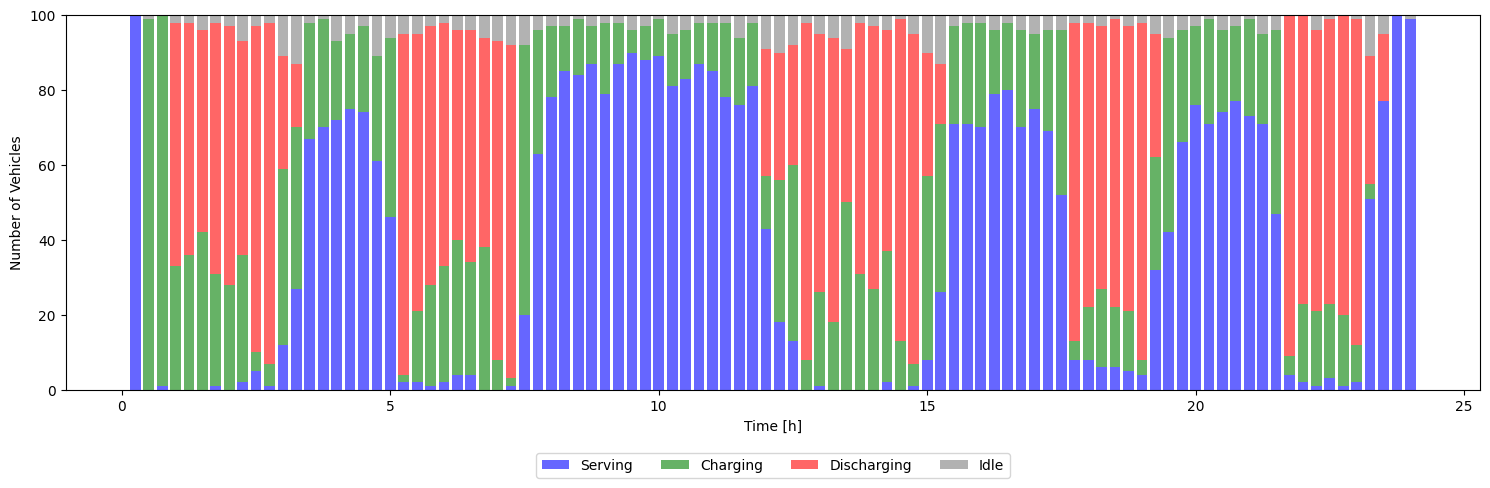

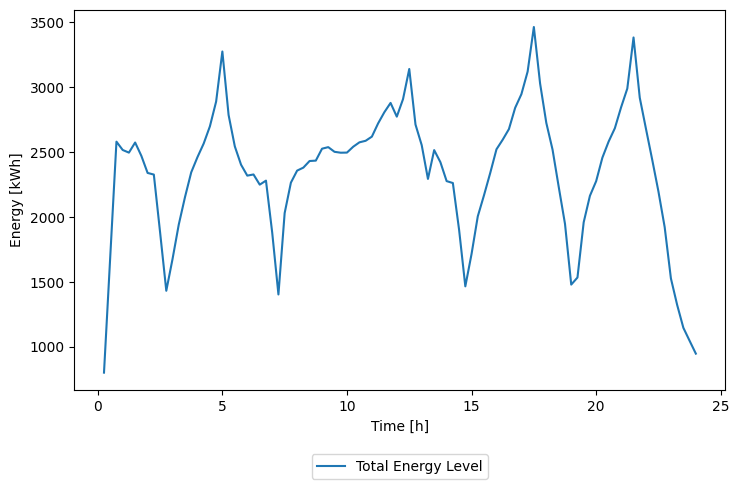

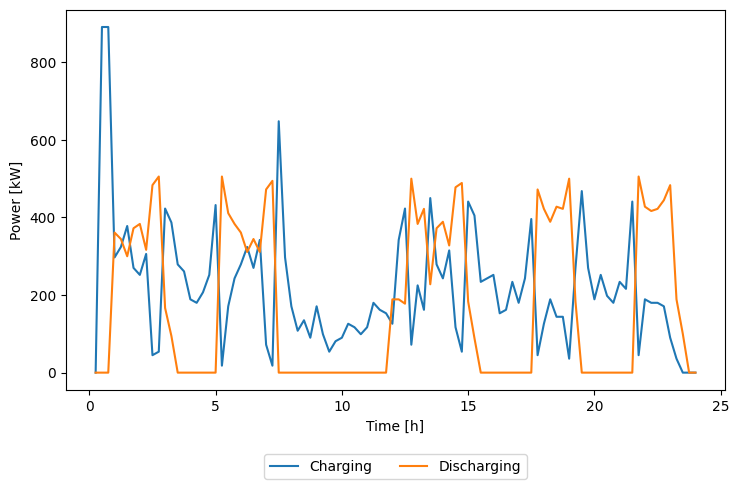

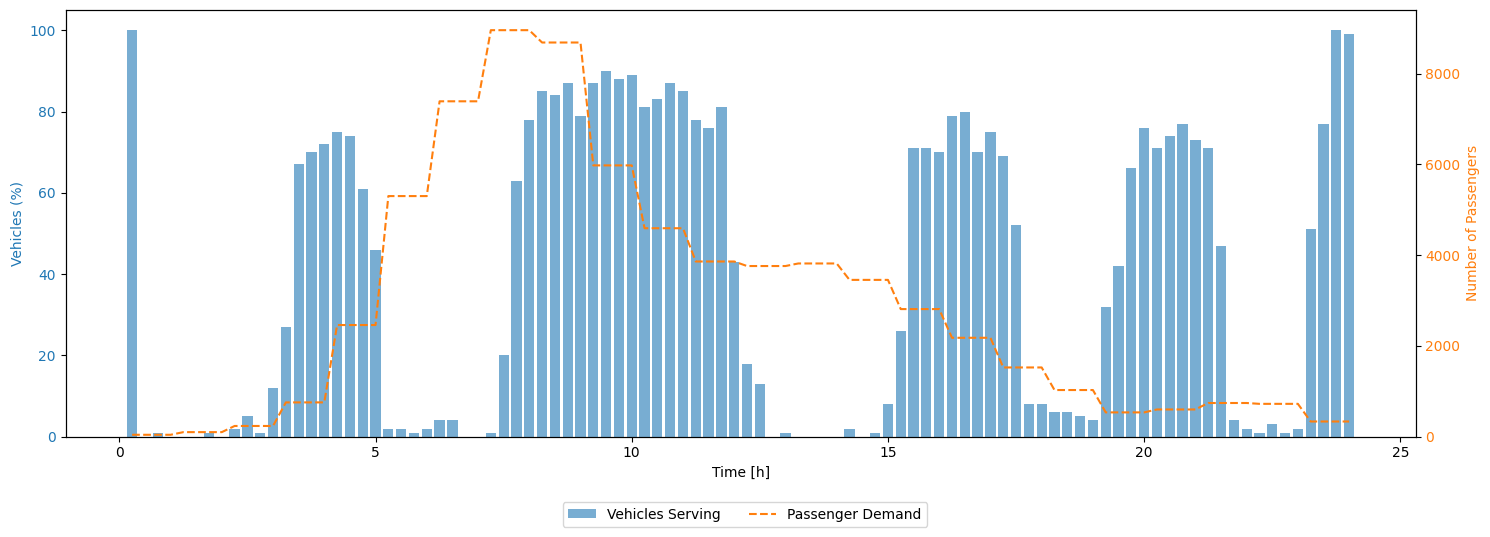

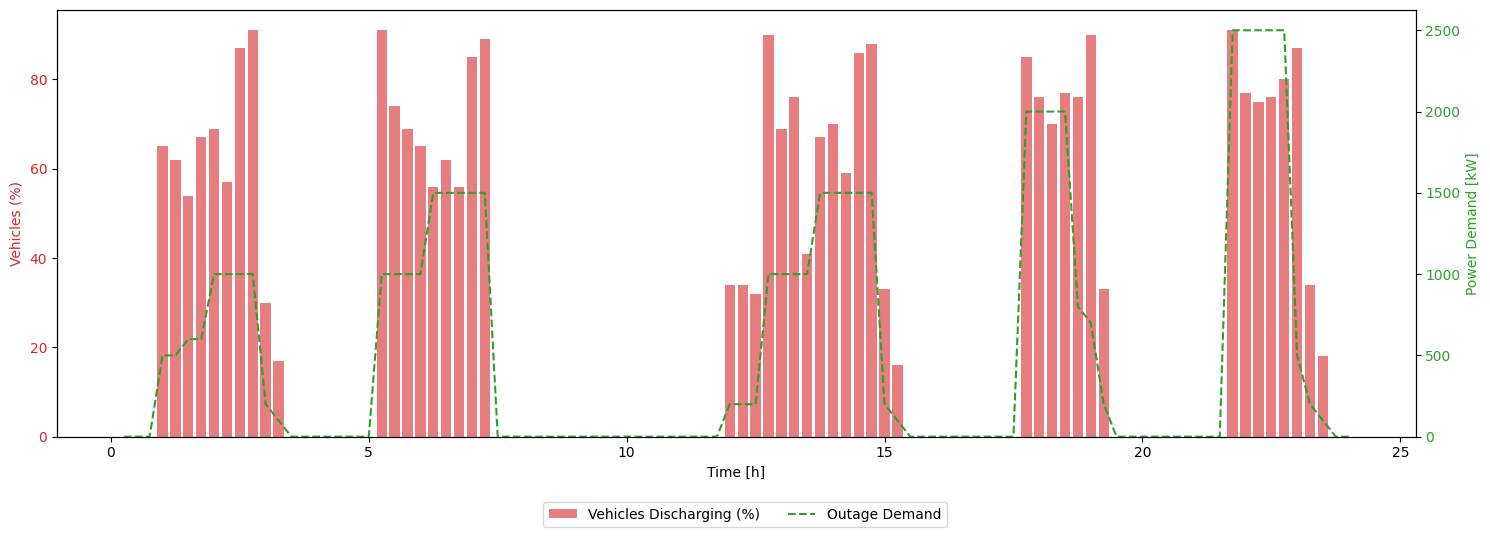

In [161]:
D_passenger = (data['Total demand']).tolist()
O_energy = (data['Outage']).tolist()
plot_variables(model, D_passenger, O_energy)

In [162]:
# Create a dynamic filename
filename = 'output_lim_outage.xlsx'

# Save results to Excel
save_to_excel(model, filename=filename)

In [163]:
#for m in np.arange(0, 1, 0.05):
#
#    D_passenger = (data['Total demand'] * m).tolist()
#    O_energy = (data['Outage'] * 20).tolist()

#    model = solve_opt(data, m)
    
    # Create a dynamic filename
#    filename = f'output_{m:.2f}.xlsx'
    
    # Save results to Excel
#    save_to_excel(model, filename=filename)
    
    # Plot variables
#    plot_variables(model, D_passenger, O_energy)